# Example Use of Lignin-KMC to Track Lignin Growth
Written by: Michael Orella <br>
Updated by: Heather Mayes <br>
2019 November 10 <br>

This notebook contains brief examples of how to use the Lignin-KMC package within python to visualize the process of lignin biosynthesis. The simulation methodology is discussed in ["Lignin-KMC: A Toolkit for Simulating Lignin Biosynthesis"](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b03534), and uses data reported in [DFT calculations of monolignol coupling kinetics](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b02506).

**Note:** this notebook directly calls various functions in the package. Users can also run Lignin-KMC from the command line, without the need to directly interact with the python code. See the [README on github](https://github.com/michaelorella/lignin-kmc).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Lignin-KMC functions and global variables used in this notebook
from ligninkmc.kmc_functions import run_kmc
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events, 
                                     create_initial_state, get_bond_type_v_time_dict)
from ligninkmc.kmc_common import (DEF_E_BARRIER_KCAL_MOL, GROW, TIME, ADJ_MATRIX, Event)

# General Math and LinAlg
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Parallelization
import joblib as par

BOND_COUNTS = 'bond counts'
FRAG_COUNTS = 'fragment length counts'
SUM_LIST = 'sum list'
STYLES_LIST = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0.6, 0), (0.6, 0, 0.6), (1, 0.5490, 0), (0, 0.6, 0.6), 
               (1, 0.8, 0), (0.6078, 0.2980, 0), (0.6, 0, 0), (0, 0, 0.6)]

Make a plotting function, and an analysis function, as they will called multiple times

In [3]:
def plot_dynamics(kmc_output):
    fig, axes = plt.subplots(1, 2, figsize=(7, 5))

    # first iteration is to get curve keys (iterate over each repeat as some keys can be in 
    #     one repeat and not another (right now, will only happen for the frag_lens)
    bond_legend_list = []
    frag_legend_list = []
    # start with a number much larger than expected simulation time
    shortest_sim_time = 1e20
    for out in kmc_output:  # iterate over the number of repeats
        bond_counts_keys = out[BOND_COUNTS].keys()
        for key in bond_counts_keys:
            if key not in bond_legend_list:
                bond_legend_list.append(key)
         
        frag_counts_keys = out[FRAG_COUNTS].keys()
        for key in frag_counts_keys:
            if key not in frag_legend_list:
                frag_legend_list.append(key)
        # different simulations can run for different amounts of time. Plot only to the shortest run time.
        final_time = out[TIME][-1]
        if final_time < shortest_sim_time:
            shortest_sim_time = final_time
    
    # for consistent output on multiple platforms
    bond_legend_list.sort()
    frag_legend_list.sort()
                
    # Now iterate to create plot
    for out in kmc_output:  # iterate over the number of repeats
        t = out[TIME]
        bond_counts_dict = out[BOND_COUNTS]
        frag_counts_dict = out[FRAG_COUNTS]
        # different lengths, so iterate separately
        for frag_idx, frag_len in enumerate(frag_legend_list):
            # only up to oligomer length 9 (index 8); then add the 10+
            if frag_idx > 8:
                break
            axes[0].plot(t, frag_counts_dict[frag_len], linestyle='-', color=STYLES_LIST[frag_idx], label=frag_len)
        if out[SUM_LIST]:
            axes[0].plot(t, out[SUM_LIST][1], linestyle='-', color=STYLES_LIST[9], label=out[SUM_LIST][0])
        for bond_idx, bond_type in enumerate(bond_legend_list):
            axes[1].plot(t, bond_counts_dict[bond_type], linestyle='-', color=STYLES_LIST[bond_idx], label=bond_type)

    axes[0].legend(axes[0].get_children()[:10], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+'], 
                   loc='best', fontsize=14)
    [axes[0].spines[i].set_linewidth(1.5) for i in ['top', 'right', 'bottom', 'left']]
    axes[0].tick_params(axis='x', which='major', labelsize=14, direction='in', pad=8, top=True, right=True,
                        width=1.5, length=5)
    axes[0].tick_params(axis='x', which='minor', labelsize=8, direction='in', pad=8, top=True, right=True, 
                        width=1, length=2.5)
    axes[0].tick_params(axis='y', which='major', labelsize=14, direction='in', pad=8, top=True, right=True,
                        width=1.5, length=4)
    axes[0].set_xlabel('Time [s]', fontsize=14)
    axes[0].set_xlim([0, shortest_sim_time])  
    axes[0].set_ylabel('# Monomers in Oligomers per Length', fontsize=14)

    axes[1].legend(axes[0].get_children()[:7], bond_legend_list, loc='best', fontsize=14)
    [axes[1].spines[i].set_linewidth(1.5) for i in ['top', 'right', 'bottom', 'left']]
    axes[1].tick_params(axis='x', which='major', labelsize=14, direction='in', pad=8, top=True, right=True,
                        width=1.5, length=5)
    axes[1].tick_params(axis='x', which='minor', labelsize=8, direction='in', pad=8, top=True, right=True, 
                        width=1, length=2.5)
    axes[1].tick_params(axis='y', which='major', labelsize=14, direction='in', pad=8, top=True, right=True,
                        width=1.5, length=4)
    axes[1].set_xlabel('Time [s]', fontsize=14)
    axes[1].set_xlim([0, shortest_sim_time])  
    axes[1].set_ylabel('# Bonds per Type', fontsize=14)

    fig.tight_layout()

In [4]:
# analysis function to be called after running the simulation
def get_traces(result):
    t_steps = result[TIME]
    adj_list = result[ADJ_MATRIX]

    sum_len_larger_than=10
    bond_type_dict, olig_monos_dict, sum_list, olig_count_dict, sum_count_list = get_bond_type_v_time_dict(adj_list, sum_len_larger_than=10)
   
    return {TIME: t_steps, BOND_COUNTS: bond_type_dict, FRAG_COUNTS: olig_monos_dict, 
            SUM_LIST: (sum_len_larger_than, sum_list)}

Here, we will use the default Gibbs free energy barriers, as reported in the [Lignin-KMC paper](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b03534), [Tables S1 and S2](https://pubs.acs.org/doi/suppl/10.1021/acssuschemeng.9b03534/suppl_file/sc9b03534_si_001.pdf), which stored in the package's global variable DEF_E_BARRIER_KCAL_MOL (imported above). 

These values can be tuned and updated to reflect new developments in better understanding of lignin chemistry. The format of the expected dictionary is shown in the [LigninPolymerizationNotebook.ipynb](LigninPolymerizationNotebook.ipynb).

Once the values have been input or imported, the `calc_rates` function uses the Eyring equation to calculate an equivalent dictionary (bond types) of dictionaries (substrate monomer types) of dictionaries (fragment sizes of substrates) of rates.

In [5]:
# Calculate the rates of reaction in 1/s at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_BARRIER_KCAL_MOL)

In [6]:
# Define the function to be run in parallel
fun = par.delayed(run_kmc)

# Set the percentage of S
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

# Here we will use a constant number of monomers: all will be available at the beginning of the simulation 
#     and no more will be added during the simulation (as in simulating a batch reactor) 
num_monos = 200

# The initial distribution of monomers will be randomly determined based on the provided S to G ratio
monomer_draw = np.random.rand(num_monos)
initial_monomers = create_initial_monomers(pct_s, monomer_draw)

# Initialize the events and state
initial_events = create_initial_events(initial_monomers, rxn_rates)
initial_state = create_initial_state(initial_events, initial_monomers)

# Now running the simulation from this initial state, for multiple repeats to provide some statistics
num_repeats = 8
# The simulation will end when the final time (in seconds) is reached, or earlier if no more reactions are possible
results = par.Parallel(n_jobs=8, verbose = 11)([fun(rxn_rates, initial_state, initial_events, n_max=num_monos, 
                                                    t_max=10000, dynamics=True) for _ in range(num_repeats)])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   47.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   48.0s remaining:  2.4min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   48.7s remaining:  1.4min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   49.2s remaining:   49.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   50.1s remaining:   30.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   50.7s remaining:   16.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   51.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   51.7s finished


In [7]:
output = par.Parallel(n_jobs=8, verbose=11)([par.delayed(get_traces)(res) for res in results])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.9min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.3min remaining:  3.9min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.0min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  3.2min remaining:  1.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.7min finished


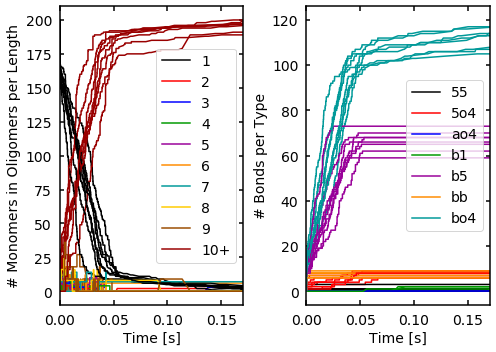

In [8]:
# FYI: the maximum time shown is the length of the simulation repeat that finished the fastest
plot_dynamics(output)

Now, a similar analysis is done for continuous monomer addition.

In [9]:
# Set the percentage of S
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

# Here we will start with 2 monomers, and add more during the simulation up to the specified maximum
ini_num_monos = 2
max_num_monos = 200
mono_add_rate = 1e4  # monomers/second

# As before, the initial distribution of monomers will be randomly determined based on the provided S to G ratio
monomer_draw = np.random.rand(ini_num_monos)
initial_monomers = create_initial_monomers(pct_s, monomer_draw)

# Initialize the events and state
initial_events = create_initial_events(initial_monomers, rxn_rates)
initial_state = create_initial_state(initial_events, initial_monomers)

# After initialization (with oxidizes monomers), add the ability to "grow" lignin by adding monomers during
#     the KMC simulation of biosynthesis, with the same sg_ratio for determining monomer types to add
initial_events.append(Event(GROW, [], rate=mono_add_rate))

# Again running the simulation from this initial state, for multiple repeats to provide some statistics
num_repeats = 8
# The simulation will still end when the final time (in seconds) is reached, or earlier if no more reactions 
#     are possible, with addition of monomers up to a maximum number included in the termination of whether 
#     additional reactions are possible
results = par.Parallel(n_jobs=8, verbose = 11)([fun(rxn_rates, initial_state, initial_events, n_max=max_num_monos, 
                                                    t_max=10000, sg_ratio=sg_ratio, dynamics=True) 
                                                for _ in range(num_repeats)])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   37.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   38.0s remaining:  1.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   38.2s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   38.9s remaining:   38.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   39.1s remaining:   23.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   39.3s remaining:   13.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   40.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   40.3s finished


In [10]:
output = par.Parallel(n_jobs=8, verbose=11)([par.delayed(get_traces)(res) for res in results])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.7min remaining:  5.2min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.9min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.5min remaining:  1.5min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.7min remaining:   53.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.0min finished


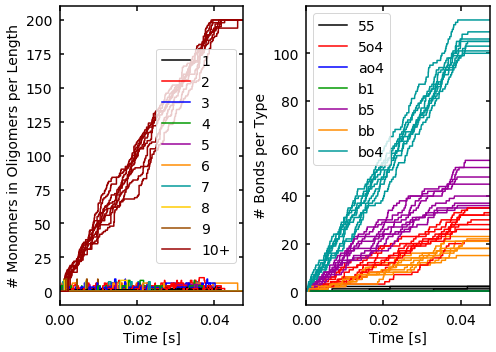

In [11]:
plot_dynamics(output)

The above simulation of continuous monomer addition will now be repeated for a larger monomer addition rate.

In [12]:
# Set the percentage of S
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

# Here we will start with 2 monomers, and add more during the simulation up to the specified maximum
ini_num_monos = 2
max_num_monos = 200
mono_add_rate = 1e9  # monomers/second

# As before, the initial distribution of monomers will be randomly determined based on the provided S to G ratio
monomer_draw = np.random.rand(ini_num_monos)
initial_monomers = create_initial_monomers(pct_s, monomer_draw)

# Initialize the events and state
initial_events = create_initial_events(initial_monomers, rxn_rates)
initial_state = create_initial_state(initial_events, initial_monomers)

# After initialization (with oxidizes monomers), add the ability to "grow" lignin by adding monomers during
#     the KMC simulation of biosynthesis, with the same sg_ratio for determining monomer types to add
initial_events.append(Event(GROW, [], rate=mono_add_rate))

# Again running the simulation from this initial state, for multiple repeats to provide some statistics
num_repeats = 8
# The simulation will still end when the final time (in seconds) is reached, or earlier if no more reactions 
#     are possible, with addition of monomers up to a maximum number included in the termination of whether 
#     additional reactions are possible
results = par.Parallel(n_jobs=8, verbose = 11)([fun(rxn_rates, initial_state, initial_events, n_max=max_num_monos, 
                                                    t_max=10000, sg_ratio=sg_ratio, dynamics=True) 
                                                for _ in range(num_repeats)])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   43.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   44.6s remaining:  2.2min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   45.3s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   46.0s remaining:   46.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   46.3s remaining:   27.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   47.1s remaining:   15.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   47.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   47.5s finished


In [13]:
output = par.Parallel(n_jobs=8, verbose=11)([par.delayed(get_traces)(res) for res in results])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.3min remaining:  4.0min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.7min remaining:  2.8min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  2.2min remaining:   44.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.7min finished


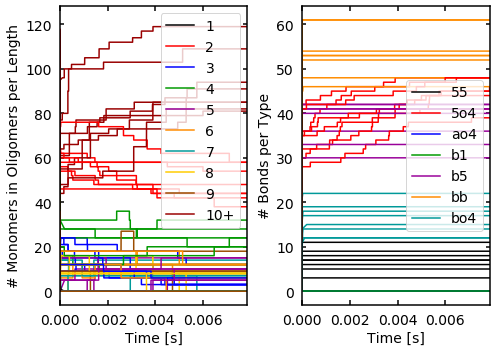

In [14]:
plot_dynamics(output)

For more information, see the [github for this project](https://github.com/michaelorella/lignin-kmc).